In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler #skala menjadi 0-1
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from collections import Counter
from sklearn.metrics import davies_bouldin_score, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
plt.style.use("fivethirtyeight")

In [2]:
data = pd.read_csv("Dataset-Tugas.csv")
data.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


# EDA

### Feature Selection

Membuang kolom `class` karena tujuan kita adalah melakukan klastering dan jika tetap dipaksakan untuk ditambahkan maka kemungkinan besar model akan sangat terpengaruh oleh kolom `class` sehingga model kurang mempelajari untuk  menemukan karakteristik data.

In [3]:
data.drop(['class'], axis=1, inplace=True)

In [4]:
data.head()

,sepal length,sepal width,petal length,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [5]:
# cek dimensi data
data.shape

(150, 4)

In [6]:
# Cek informasi dataset 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal length  150 non-null    float64
 1   sepal width   150 non-null    float64
 2   petal length  150 non-null    float64
 3   petal width   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


In [7]:
# cek nilai kosong
data.isnull().sum()

sepal length    0
sepal width     0
petal length    0
petal width     0
dtype: int64

In [8]:
# cek data duplikat
data.duplicated().sum()

np.int64(3)

In [9]:
# drop data duplikat
data.drop_duplicates(inplace=True)

In [10]:
# cek nilai statistika deskriptif tiap kolom
data.describe().T

,count,mean,std,min,25%,50%,75%,max
sepal length,147.0,5.856463,0.829100,4.3,5.1,5.8,6.4,7.9
sepal width,147.0,3.055782,0.437009,2.0,2.8,3.0,3.3,4.4
petal length,147.0,3.780272,1.759111,1.0,1.6,4.4,5.1,6.9
petal width,147.0,1.208844,0.757874,0.1,0.3,1.3,1.8,2.5


**Heatmap**

Dari hasil heatmap dibawah terdapat beberapa data yang memiliki multikolinearitas yang kuat seperti hubungan kolom `petal length` dan `petal width`. Hubungan linear yang kuat antar variabel dapat sangat mempengaruhi hasil klastering. 

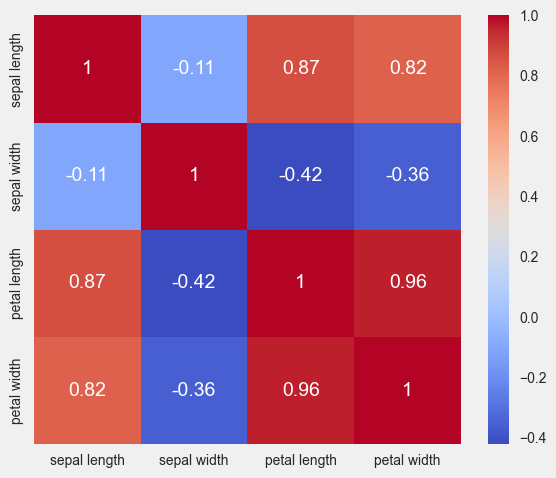

In [11]:
plt.figure(figsize=(6, 5))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.tight_layout()
plt.show()

**Histogram & Scatter plot**

Dari gambaran histogram dan hasil nilai skewness dibawah dapat disimpulkan bahwa distribusi data masih terbilang cukup simetris dengan -0.5 < nilai < 0.5. Dari nilai kurtosisnya, distribisi data bersifat Platykurtik yaitu distribusi memiliki ekor yang ringan sehingga minim outliers.
Untuk scatterplot terdapat beberapa hubungan variabel yang menggambarkan data secara linear yang menandakan hubungannya kuat.  

<Figure size 1500x1500 with 0 Axes>

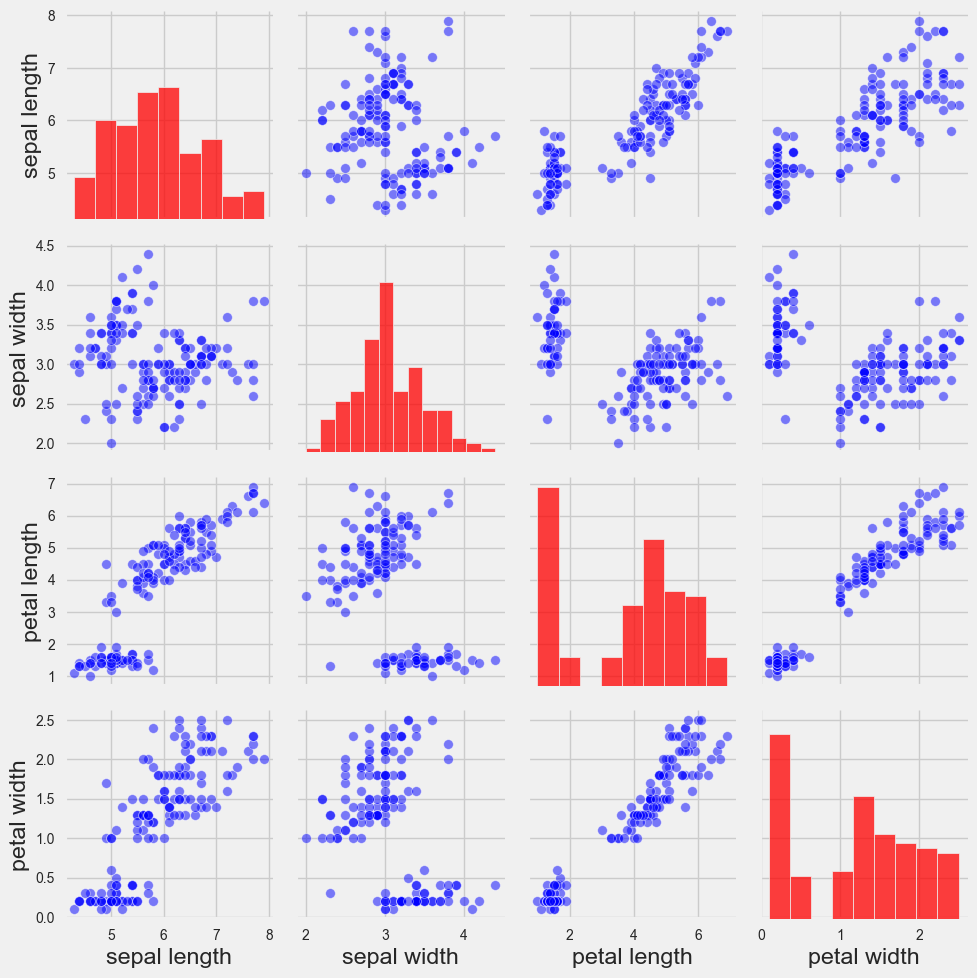

In [12]:
plt.figure(figsize=(15, 15))
sns.pairplot(data, plot_kws={'color':'blue', 'alpha':0.5}, diag_kws={'color': 'red'})
plt.tight_layout()
plt.show()

In [13]:
# cek skewness
for i in data.columns:
    print(f"{i}: {data[i].skew()}")

sepal length: 0.29255956516307163
sepal width: 0.3243506195620299
petal length: -0.2937634574565383
petal width: -0.11347861374619836


In [29]:
# cek kurtosis
for i in data.columns:
    print(f"{i}: {data[i].kurt()}")

sepal length: -0.5569564812003911
sepal width: 0.24683840744328434
petal length: -1.3744621135069286
petal width: -1.3177600111364542
Hasil_cluster: -1.4613454951817024


**Boxplot**

Dari hasil boxplot, terdapat bebrapa outlier pada kolom `sepal width`. Sebenarnya outlier dapat berpengaruh dalam penentuan titik centorid algoritma K-Means tetapi setelah beberapa kali trial&error saya memutuskan untuk membiarkannya karena memperburuk akurasi model. 

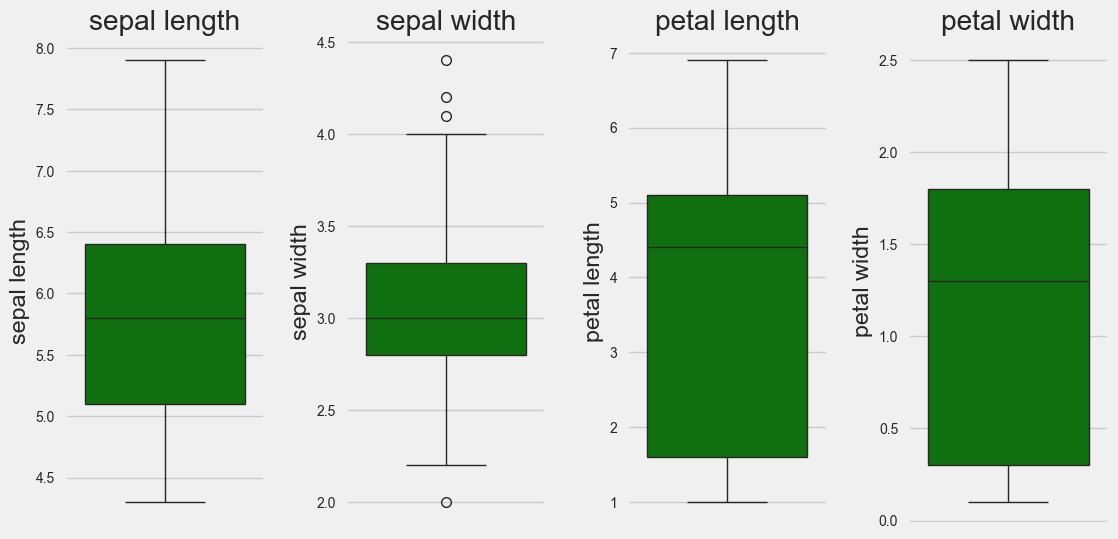

In [14]:
def box_plot(data):
  # definisi variabel
  variables = data.select_dtypes(exclude='object').columns

  # membuat figure plot
  fig, axes = plt.subplots(1, 4, figsize=(12, 6))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  # iterasi
  for i, var in enumerate(variables):
    sns.boxplot(y=var, data=data, color="green", ax=axes[i])
    axes[i].set_title(var)  # tambahkan judul untuk setiap plot

  # tampilkan plot
  plt.show()

# panggil lagi fungsi
box_plot(data)

# Preprocessing

### Scaling Data

Melakukan pengskalakan data dengan range 0-1 menggunakan algoritma minmaxscaler. Scaling penting karena penentuan titik centroid berdasarkan pada jarak euclidean sehingga jika tidak dilakukan scaling maka titik centroid akan condong ke data yang skalanya besar. 

In [15]:
scaler = MinMaxScaler() # inisialisasi

X_scaled = scaler.fit_transform(data) # fit transform
X_scaled

array([[0.22222222, 0.625     , 0.06779661, 0.04166667],
       [0.16666667, 0.41666667, 0.06779661, 0.04166667],
       [0.11111111, 0.5       , 0.05084746, 0.04166667],
       [0.08333333, 0.45833333, 0.08474576, 0.04166667],
       [0.19444444, 0.66666667, 0.06779661, 0.04166667],
       [0.30555556, 0.79166667, 0.11864407, 0.125     ],
       [0.08333333, 0.58333333, 0.06779661, 0.08333333],
       [0.19444444, 0.58333333, 0.08474576, 0.04166667],
       [0.02777778, 0.375     , 0.06779661, 0.04166667],
       [0.16666667, 0.45833333, 0.08474576, 0.        ],
       [0.30555556, 0.70833333, 0.08474576, 0.04166667],
       [0.13888889, 0.58333333, 0.10169492, 0.04166667],
       [0.13888889, 0.41666667, 0.06779661, 0.        ],
       [0.        , 0.41666667, 0.01694915, 0.        ],
       [0.41666667, 0.83333333, 0.03389831, 0.04166667],
       [0.38888889, 1.        , 0.08474576, 0.125     ],
       [0.30555556, 0.79166667, 0.05084746, 0.125     ],
       [0.22222222, 0.625     ,

# Modeling

## K-Means

**MEMBUAT DIAGRAM ELBOW**

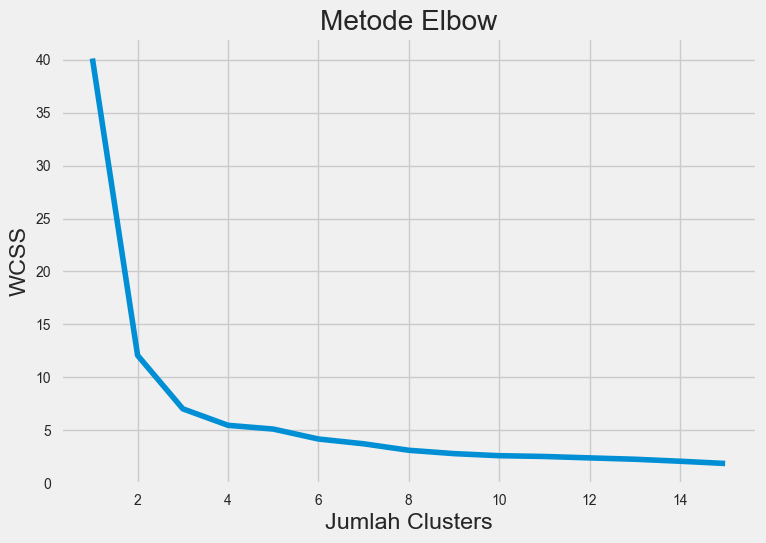

In [16]:
#Menggunakan metode elbow untuk menentukan jumlah claster yang sesuai
wcss = []
for i in range (1,16):
  kmeans = KMeans (n_clusters = i, init = 'k-means++', random_state = 42)
  kmeans.fit(X_scaled)
  wcss.append(kmeans.inertia_)
plt.plot(range(1,16), wcss)
plt.title('Metode Elbow')
plt.xlabel('Jumlah Clusters')
plt.ylabel('WCSS')
plt.show()

In [17]:
# Menjalankan K-Means clustering ke dataset
model1 = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
Label_K_Means = model1.fit_predict(X_scaled)

In [18]:
Label_K_Means

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

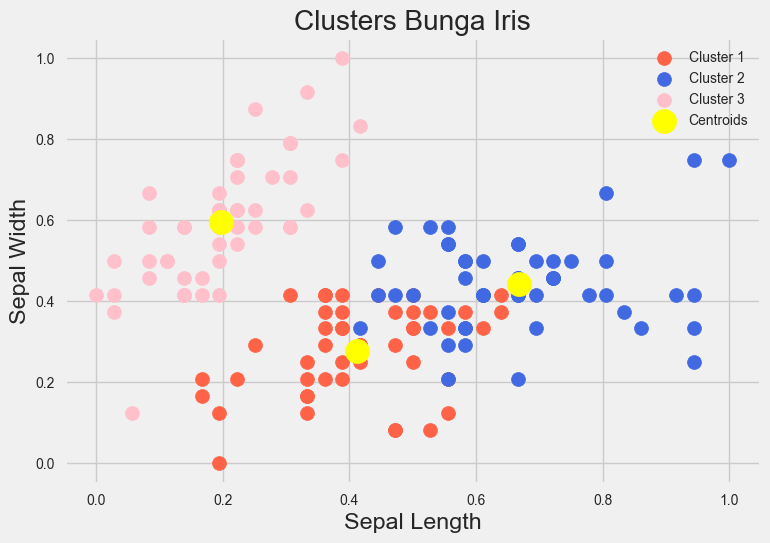

In [19]:
#visualisasi hasil cluster
plt.scatter (X_scaled[Label_K_Means == 0, 0], X_scaled[Label_K_Means == 0, 1],
             s = 100, c = 'tomato', label = 'Cluster 1')

plt.scatter (X_scaled[Label_K_Means == 1, 0], X_scaled[Label_K_Means == 1,1],
             s = 100, c = '#4169E1', label = 'Cluster 2')

plt.scatter (X_scaled[Label_K_Means == 2,0], X_scaled[Label_K_Means == 2,1],
             s = 100, c = 'pink', label = 'Cluster 3')

plt.scatter (model1.cluster_centers_[:,0], model1.cluster_centers_[:,1],
             s = 300, c = 'yellow', label = 'Centroids')

plt.title('Clusters Bunga Iris')
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.legend()
plt.show()

## DB-SCAN

In [20]:
#Membuat objek dbscan dengan parameter epsilon dan jumlah minimum
model2 = DBSCAN(eps=0.4, min_samples=5)

#Melakukan clustering
model2.fit(X_scaled)

#mendapatkan label untuk setiap data (-1 menandakan noise)
Label_DB_Scan = model2.labels_

In [21]:
Label_DB_Scan

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [22]:
data['Hasil_cluster'] = model2.labels_ #simpan sebagai kolom baru hasil cluster didataset
data.head()

,sepal length,sepal width,petal length,petal width,Hasil_cluster
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


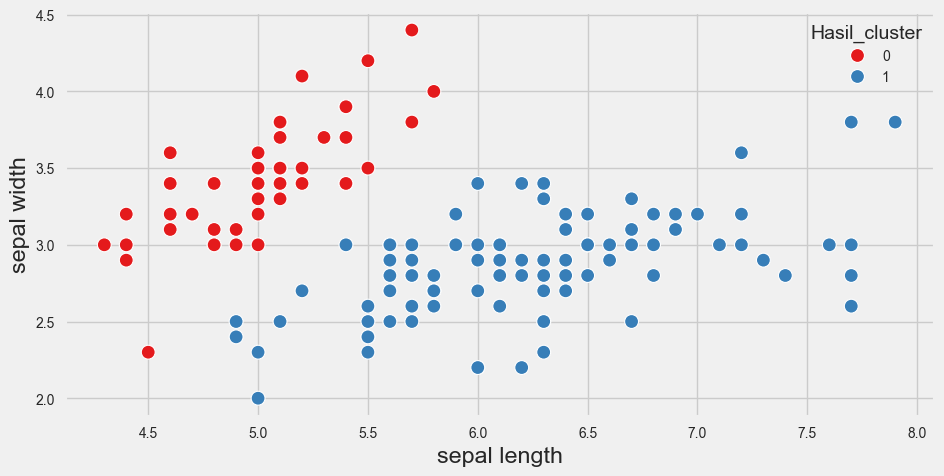

In [23]:
plt.figure(figsize=(10,5))
sns.scatterplot(x= 'sepal length', y = 'sepal width',
                hue = 'Hasil_cluster', data = data, palette = 'Set1', s = 100);

# MATRIKS EVALUASI

## 1. Silhouette

**K-Means**

Dari nilai Silhouette 48% dapat disimpulkan model cukup jelas memisahkan data dan menentukan kelas klastering. Nilai Silhouette score memiliki range [-1,1], semaikin nilai mendekati 1 maka semakin baik juga model dalam melakukan klastering

In [24]:
Evaluasi_KMeans = silhouette_score(X_scaled, Label_K_Means)
print("Silhouette score: ", Evaluasi_KMeans)

Silhouette score:  0.4826957689193649


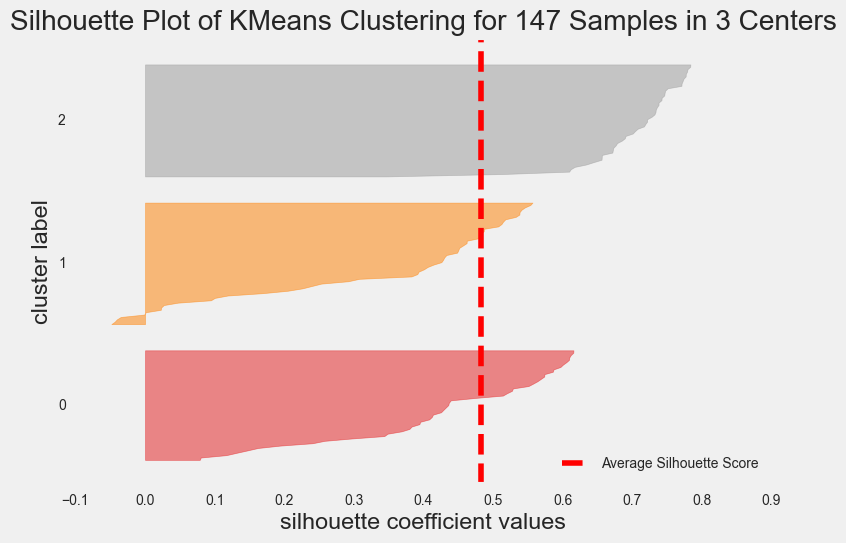

In [25]:
silhouette_viz = SilhouetteVisualizer(model1) #untuk algoritma K-MEANS
silhouette_viz.fit(X_scaled)
plt.grid(False)
silhouette_viz.show()
plt.show()

**DB-Scan**

Hasil dari silhouette mennjukan nilai 62 % apat disimpulkan model lebih jelas memisahkan data dan menentukan kelas klastering dibanding model K-Means.

In [26]:
Evaluasi_DBScan = silhouette_score(X_scaled, Label_DB_Scan)
print("Silhouette score: ", Evaluasi_DBScan)

Silhouette score:  0.6263676933057732


## 2.Davies Bouldin Index (DBI)

Nilai DBI dari model K-Means menunjukan nilai 77 % dan untuk model DB-Scan 49 %. Semakin kecil nilai DBI maka semakin baik modelnya  

In [27]:
#Menghitung davies bouldin indeks algoritma k-means
doi_score1 = davies_bouldin_score(X_scaled, Label_K_Means)
print("Davies Bouldin Index (DBBI):", doi_score1)

Davies Bouldin Index (DBBI): 0.779076833345893


In [28]:
#Menghitung davies bouldin indeks algoritma DB-Scan
doi_score2 = davies_bouldin_score(X_scaled, Label_DB_Scan)
print("Davies Bouldin Index (DBBI):", doi_score2)

Davies Bouldin Index (DBBI): 0.49027098344512404


# Kesimpulan 

Untuk kasus klastering dataset iris, Model dengan algoritma DB-Scan memberikan peforma yang lebih baik. Walaupun begitu algoritma DB-Scan hanya memberikan 2 Kelas yang padahal dalam kenyataannya Dataset iris memiliki 3 kelas.